# 目標
- 小さなデータでsubmissionを目指す.

In [1]:
import sys
sys.path.append("../yandex/")
#sys.path.append("../lib/")
import os
import pandas as pd

import utils
import scoring
import calc_var as cv

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
import catboost
import swifter

from hyperopt import fmin, tpe, hp, rand
import optuna

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
%load_ext autoreload

pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 200)

Using TensorFlow backend.
/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# データの準備

In [2]:
DATA_PATH = "../your_data_dir/"

In [3]:
train, test = utils.load_data_csv(
    DATA_PATH, utils.SIMPLE_FEATURE_COLUMNS)

/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



## event数を絞る

In [4]:
sample = train.sample(1000000)

In [5]:
sample.head()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  \
2974472      14       3       6      15   1.500000   1.000000   1.166667   
2103428      54       6       5      13   2.333333   1.166667   1.200000   
3049673      79      23       9      15   2.417721   2.260870   1.333333   
5184128      65      10      13       6   1.953846   1.300000   1.076923   
167000       17       5       5      10   1.529412   1.000000   1.000000   

         avg_cs[3]  ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
2974472   1.066667     8                   2                   2   
2103428   2.076923     8                   2                   2   
3049673   1.400000     8                   2                   2   
5184128   1.333333     6                   1                   2   
167000    1.300000     8                   2                   2   

         MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  \
2974472                   2                   2          971.925   
2103428                   2                   2         2113.600   
3049673                   2                   2         2130.600   
5184128                   2                   0           23.600   
167000                    2                   2         1374.100   

         MatchedHit_X[1]  MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  \
2974472         1061.935          1147.60          1227.22       -598.75840   
2103428         2250.560          2310.60          2467.82      -1975.25330   
3049673         2326.560          2512.60          2685.82       1937.22750   
5184128           14.985          -273.87         -9999.00        423.13492   
167000          1480.560          1602.60          1711.82       1082.72680   

         MatchedHit_Y[1]  MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  \
2974472       -646.10443       -693.48110        -741.1728        15201.844   
2103428      -2129.29860      -2283.47460       -2437.8657        15397.888   
3049673       1954.38120       2097.90330        2241.1104        15126.975   
5184128        319.93930        620.19995       -9999.0000        15205.523   
167000        1166.68000       1250.70250        1334.4099        15408.899   

         MatchedHit_Z[1]  MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  \
2974472        16408.973        17602.402        18811.130             6.375   
2103428        16604.633        17797.678        19006.021            12.750   
3049673        16334.337        17528.453        18737.870            12.750   
5184128        16412.451        17718.334        -9999.000            19.250   
167000         16616.502        17810.404        19019.605            12.750   

         MatchedHit_DX[1]  MatchedHit_DX[2]  MatchedHit_DX[3]  \
2974472          6.875000              29.5              31.5   
2103428         13.750000              59.0              63.0   
3049673         13.750000              59.0              63.0   
5184128          3.458333              29.5           -9999.0   
167000          13.750000              59.0              63.0   

         MatchedHit_DY[0]  MatchedHit_DY[1]  MatchedHit_DY[2]  \
2974472         31.479162         33.979145         36.479130   
2103428         63.078957         68.078926         73.078896   
3049673         63.078957         68.078926         73.078896   
5184128         15.679264         16.929256         36.479130   
167000          63.078957         68.078926         73.078896   

         MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  \
2974472         38.979115         33.613575         33.622578   
2103428         78.078860         33.727364         33.745370   
3049673         78.078860         33.727364         33.745370   
5184128      -9999.000000         33.556680         33.561180   
167000          78.078860         33.727364         33.745370   

         MatchedHit_DZ[2]  MatchedHit_DZ[3]  MatchedHit_T[0]  MatchedHit_T[1]  \
2974472         33.631580         33.640583      

## 新しい特徴量を追加する

In [6]:
%autoreload

In [7]:
sample = (cv.MeasCalculator()).calc_all(sample)

In [8]:
#sample = sample.swifter.apply(
#    cv.RowWiseCalculator().calc_all, result_type="expand", axis=1)

In [9]:
sample.head()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  \
777649       67       8      27      17   2.805970   1.750000   1.444444   
5247581      54      19      15      12   2.203704   1.842105   1.266667   
4058164      35      12       6       7   2.685714   2.333333   1.500000   
3176862     108      22      12       6   2.898148   3.545454   1.500000   
2369723     127      17       8      12   3.299213   1.941176   1.250000   

         avg_cs[3]  ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
777649    1.117647     8                   2                   2   
5247581   1.416667     8                   2                   2   
4058164   1.428572     8                   2                   2   
3176862   1.000000     8                   2                   2   
2369723   1.166667     8                   2                   2   

         MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  \
777649                    2                   2         2190.100   
5247581                   2                   2         -355.805   
4058164                   2                   2         1412.350   
3176862                   2                   2          653.175   
2369723                   1                   1         -433.505   

         MatchedHit_X[1]  MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  \
777649        2388.06000        2546.6000        2719.8200       1082.72680   
5247581       -398.47500        -448.5700        -479.9700       -662.44120   
4058164       1686.81000        2015.6000        2656.8200       3184.51320   
3176862        718.18500         793.6000         849.2200        910.33180   
2369723       -482.50833        -520.3367        -588.4033        359.45218   

         MatchedHit_Y[1]  MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  \
777649        1166.68000       1250.70250       1334.40990        15408.899   
5247581       -715.72595       -767.78973       -818.31854        15199.714   
4058164       3432.26540       3680.08670       3927.49320        15416.469   
3176862        981.98500       1126.90710       1203.21460        15207.277   
2369723        386.71690        415.30260        445.32324        15203.394   

         MatchedHit_Z[1]  MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  \
777649         16616.502        17810.404        19019.605         12.750000   
5247581        16403.723        17596.334        18804.252          6.375000   
4058164        16624.660        17819.152        19028.943         25.500000   
3176862        16414.836        17608.957        18818.133          6.375000   
2369723        16407.691        17600.596        18808.803          3.208333   

         MatchedHit_DX[1]  MatchedHit_DX[2]  MatchedHit_DX[3]  \
777649          13.750000         59.000000         63.000000   
5247581          6.875000         29.500000         31.500000   
4058164         27.500000        118.000000        126.000000   
3176862          6.875000         29.500000         31.500000   
2369723          3.458333         14.833333         15.833333   

         MatchedHit_DY[0]  MatchedHit_DY[1]  MatchedHit_DY[2]  \
777649          63.078957         68.078926         73.078896   
5247581         31.479162         33.979145         36.479130   
4058164        126.278550        136.278490        146.278410   
3176862         31.479162         33.979145         36.479130   
2369723         15.679264         16.929256         18.179249   

         MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  \
777649          78.078860         33.727364         33.745370   
5247581         38.979115         33.613575         33.622578   
4058164        156.278350         33.954950         33.990960   
3176862         38.979115         33.613575         33.622578   
2369723         19.429240         33.556680         33.561180   

         MatchedHit_DZ[2]  MatchedHit_DZ[3]  MatchedHit_T[0]  MatchedHit_T[1]  \
777649          33.763374         33.781380      

In [10]:
sample.columns

Index(['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       ...
       'sq_chi_modelY2', 'sq_chi_bothY2', 'sq_chi_physX3', 'sq_chi_modelX3',
       'sq_chi_bothX3', 'sq_chi_physY3', 'sq_chi_modelY3', 'sq_chi_bothY3',
       'sq_PT', 'sq_P'],
      dtype='object', length=145)

In [11]:
sample.dtypes

ncl[0]                       int64
ncl[1]                       int64
ncl[2]                       int64
ncl[3]                       int64
avg_cs[0]                  float64
avg_cs[1]                  float64
avg_cs[2]                  float64
avg_cs[3]                  float64
ndof                         int64
MatchedHit_TYPE[0]           int64
MatchedHit_TYPE[1]           int64
MatchedHit_TYPE[2]           int64
MatchedHit_TYPE[3]           int64
MatchedHit_X[0]            float64
MatchedHit_X[1]            float64
MatchedHit_X[2]            float64
MatchedHit_X[3]            float64
MatchedHit_Y[0]            float64
MatchedHit_Y[1]            float64
MatchedHit_Y[2]            float64
MatchedHit_Y[3]            float64
MatchedHit_Z[0]            float64
MatchedHit_Z[1]            float64
MatchedHit_Z[2]            float64
MatchedHit_Z[3]            float64
MatchedHit_DX[0]           float64
MatchedHit_DX[1]           float64
MatchedHit_DX[2]           float64
MatchedHit_DX[3]    

In [8]:
test = (cv.MeasCalculator()).calc_all(test)

In [13]:
#test = test.swifter.apply(
#    cv.RowWiseCalculator().calc_all, result_type="expand", axis=1)

## カラムを絞る
- とりあえず以下のものだけ抜き出す.
    - 評価用
        - label
        - weight
        - particle_type
    - 特徴量
        - PT
        - P
        - FOI_hits_N
        - ncl[0]
        - avg_cs[0]

In [9]:
FEATURE_COLUMNS2 = ['PT', 'PCat','InvASD3', 'FOI_hits_N']

In [10]:
FEATURE_COLUMNS = FEATURE_COLUMNS2 + ['label', 'weight']

In [11]:
ID_COLUMNS = ['particle_type']

In [12]:
ID_COLUMNS2 = ['particle_type', 'label', 'weight']

## train test split

In [13]:
splite_ratio = 0

In [14]:
X_selected = sample[FEATURE_COLUMNS]

In [15]:
y_selected = sample[ID_COLUMNS]

In [16]:
X_train_selected0, X_test0, y_train_selected, y_test = train_test_split(X_selected, y_selected, test_size=splite_ratio, random_state=42)


In [17]:
X_train_selected = X_train_selected0[FEATURE_COLUMNS2]
X_test = X_test0[FEATURE_COLUMNS2]

In [18]:
y_train_selected = pd.concat([y_train_selected, X_train_selected0[['label', 'weight']]], axis=1)
y_test = pd.concat([y_test, X_test0[['label', 'weight']]], axis=1)

In [19]:
selected = pd.concat([X_train_selected, y_train_selected], axis=1)

In [100]:
selected.head()

PT  PCat   InvASD3  FOI_hits_N  particle_type  label  \
3852671  1318.649209     4  0.177409           5              1      1   
2047006  1710.087457     4  0.910609          12              1      1   
999162    827.718036     1  0.065705          51              1      1   
2928481  4337.413268     5  0.160598           5              1      1   
54305    3831.144186     3  0.600456           5              1      1   

           weight  
3852671  0.664849  
2047006  2.734812  
999162  -1.201174  
2928481  1.967310  
54305    4.662052

In [61]:
selected.dtypes

PT               float64
PCat               int64
InvASD3          float64
particle_type      int64
label              int64
weight           float64
dtype: object

In [62]:
X_test.head()

Empty DataFrame
Columns: [PT, PCat, InvASD3]
Index: []

In [63]:
y_test.describe()

particle_type  label  weight
count            0.0    0.0     0.0
mean             NaN    NaN     NaN
std              NaN    NaN     NaN
min              NaN    NaN     NaN
25%              NaN    NaN     NaN
50%              NaN    NaN     NaN
75%              NaN    NaN     NaN
max              NaN    NaN     NaN

## muonのeventを削る
- アンダーサンプリング

In [20]:
muons = len(selected[selected['particle_type']==1])
print("muons: "+ str(muons))
pions = len(selected[selected['particle_type']==0])
print("pions: "+ str(pions))
protons = len(selected[selected['particle_type']==2])
print("protons: "+ str(protons))

muons: 922702
pions: 46730
protons: 30568


In [21]:
# muon /protons
ratio = 5
#muons_number = protons * ratio
#pions_number = protons * 1
#protons_number = protons
muons_number = muons
protons_number = protons
pions_number = pions

In [22]:
#muon_under_sampled = selected.sample(muons_number)
pion_under_sampled = selected[selected['particle_type']==0].sample(pions_number)
muon_under_sampled = selected[selected['particle_type']==1].sample(muons_number)
proton_under_sampled = selected[selected['particle_type']==2].sample(protons_number)

In [23]:
selected_under_sampled = pd.concat([muon_under_sampled, 
                                                                    proton_under_sampled, 
                                                                    pion_under_sampled])

In [24]:
muons = len(selected_under_sampled[selected_under_sampled['particle_type']==1])
print("muons: "+ str(muons))
pions = len(selected_under_sampled[selected_under_sampled['particle_type']==0])
print("pions: "+ str(pions))
protons = len(selected_under_sampled[selected_under_sampled['particle_type']==2])
print("protons: "+ str(protons))

muons: 922702
pions: 46730
protons: 30568


In [69]:
selected_under_sampled.describe()

PT           PCat        InvASD3  particle_type  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean     2406.782096       4.008050       0.490097       0.983705   
std      1993.760251       2.185054       0.826199       0.277633   
min       800.011031       0.000000       0.001169       0.000000   
25%      1189.382823       3.000000       0.144296       1.000000   
50%      1767.224121       4.000000       0.268402       1.000000   
75%      2880.410207       5.000000       0.523426       1.000000   
max     55868.677325       8.000000      54.912315       2.000000   

               label         weight  
count  200000.000000  200000.000000  
mean        0.922655       3.496552  
std         0.267139      30.851638  
min         0.000000   -1868.212725  
25%         1.000000       1.450084  
50%         1.000000       2.190361  
75%         1.000000       2.857517  
max         1.000000    1852.652646

In [70]:
#sns.pairplot(selected_under_sampled, hue='particle_type')

## train split

In [25]:
X_train = selected_under_sampled[FEATURE_COLUMNS2]
y_train = selected_under_sampled[ID_COLUMNS2]

In [72]:
X_train.head()

PT  PCat   InvASD3
1815020  3917.710053     5  0.487370
207720   1932.299956     3  0.516937
4091659  2304.822679     3  0.115082
938158   1823.053957     3  0.429089
1915129  2725.874350     3  0.196974

In [73]:
y_train.head()

particle_type  label    weight
1815020              1      1  3.069290
207720               1      1  2.296374
4091659              1      1  1.608497
938158               1      1  1.493016
1915129              1      1  1.937654

In [74]:
y_train.head()

particle_type  label    weight
1815020              1      1  3.069290
207720               1      1  2.296374
4091659              1      1  1.608497
938158               1      1  1.493016
1915129              1      1  1.937654

# 学習

### データの確認

In [75]:
X_train.head()

PT  PCat   InvASD3
1815020  3917.710053     5  0.487370
207720   1932.299956     3  0.516937
4091659  2304.822679     3  0.115082
938158   1823.053957     3  0.429089
1915129  2725.874350     3  0.196974

In [76]:
X_train.describe()

PT           PCat        InvASD3
count  200000.000000  200000.000000  200000.000000
mean     2406.782096       4.008050       0.490097
std      1993.760251       2.185054       0.826199
min       800.011031       0.000000       0.001169
25%      1189.382823       3.000000       0.144296
50%      1767.224121       4.000000       0.268402
75%      2880.410207       5.000000       0.523426
max     55868.677325       8.000000      54.912315

In [77]:
y_train.head()

particle_type  label    weight
1815020              1      1  3.069290
207720               1      1  2.296374
4091659              1      1  1.608497
938158               1      1  1.493016
1915129              1      1  1.937654

In [78]:
y_train.describe()

particle_type          label         weight
count  200000.000000  200000.000000  200000.000000
mean        0.983705       0.922655       3.496552
std         0.277633       0.267139      30.851638
min         0.000000       0.000000   -1868.212725
25%         1.000000       1.000000       1.450084
50%         1.000000       1.000000       2.190361
75%         1.000000       1.000000       2.857517
max         2.000000       1.000000    1852.652646

### CatBoostの設定

In [26]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]

In [80]:
categorical_features_indices

array([1])

### optunaを使ったhyper parameter tuning

In [27]:
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    depth = trial.suggest_int('depth', 1, 10)
    l2_leaf_reg = trial.suggest_discrete_uniform('l2_leaf_reg', 1, 9, 4)
        
    n_folds = 2
    score = 0.0
    test_size = float(1/n_folds)
    for i in range(n_folds):
            Xtr, Xts, ytr, yts = train_test_split(X_train, y_train, 
                                                  test_size = test_size, shuffle = True)
            
            model = catboost.CatBoostClassifier(iterations=500, 
                                        learning_rate = learning_rate, depth = depth)
            model.fit(Xtr, ytr['label'], verbose = False)
            predictions_score_predict = model.predict_proba(Xts)[:,1]
            labels_score_predict = yts['label'].values
            weights_score_predict = yts['weight'].values
            score_tmp = scoring.rejection90(labels_score_predict, predictions_score_predict, weights_score_predict)
            print(score_tmp)
            score += score_tmp
            
    score /= n_folds
    return 1 - score

In [28]:
study = optuna.create_study()

In [34]:
#study.optimize(objective, n_trials=1)
study.optimize(objective, n_trials=100)

403654 403654 57841
0.7996901357691591 0.7996901357691591
0.6697357194914381
403462 403462 57746
0.800708503831579 0.800708503831579
0.6987867267487755


[I 2019-02-04 21:04:37,807] Finished a trial resulted in value: 0.31573877687989316. Current best value is 0.2986707568849982 with parameters: {'learning_rate': 0.05725425937426972, 'depth': 4, 'l2_leaf_reg': 8.0}.


403154 403154 58294
0.9403447945107312 0.9403447945107312
0.7118462795865452
402905 402905 58421
0.9405359283755059 0.9405359283755059
0.6914990958118752


[I 2019-02-04 21:07:09,267] Finished a trial resulted in value: 0.2983273123007898. Current best value is 0.2983273123007898 with parameters: {'learning_rate': 0.008144101485423999, 'depth': 6, 'l2_leaf_reg': 1}.


402888 402888 58247
0.9397525568217383 0.9397525568217383
0.704309351169711
402752 402754 58509
0.9393336515451944 0.9393313451310409
0.6988386999991261


[I 2019-02-04 21:08:37,808] Finished a trial resulted in value: 0.2984259744155815. Current best value is 0.2983273123007898 with parameters: {'learning_rate': 0.008144101485423999, 'depth': 6, 'l2_leaf_reg': 1}.


403424 403424 57896
0.9260090818453331 0.9260090818453331
0.7241177543063917
403154 403154 58157
0.9258208487256595 0.9258208487256595
0.7147160432676354


[I 2019-02-04 21:10:19,647] Finished a trial resulted in value: 0.28058310121298646. Current best value is 0.28058310121298646 with parameters: {'learning_rate': 0.003635637585177235, 'depth': 3, 'l2_leaf_reg': 8.0}.


403308 403308 57892
0.9395111286277519 0.9395111286277519
0.7224060840665166
402918 402918 58182
0.9393427801835202 0.9393427801835202
0.7094787488862012


[I 2019-02-04 21:12:21,671] Finished a trial resulted in value: 0.2840575835236411. Current best value is 0.28058310121298646 with parameters: {'learning_rate': 0.003635637585177235, 'depth': 3, 'l2_leaf_reg': 8.0}.


403220 403220 58069
0.912358506945879 0.912358506945879
0.7327182142163771
403146 403146 58105
0.9108265629509967 0.9108265629509967
0.7103431483555095


[I 2019-02-04 21:14:05,959] Finished a trial resulted in value: 0.2784693187140568. Current best value is 0.2784693187140568 with parameters: {'learning_rate': 0.0028277775776353875, 'depth': 3, 'l2_leaf_reg': 8.0}.


403264 403264 57922
0.938452670279802 0.938452670279802
0.6922050888446001
403166 403166 58334
0.9372654565795943 0.9372654565795943
0.7195656994142096


[I 2019-02-04 21:16:20,917] Finished a trial resulted in value: 0.29411460587059524. Current best value is 0.2784693187140568 with parameters: {'learning_rate': 0.0028277775776353875, 'depth': 3, 'l2_leaf_reg': 8.0}.


403254 403254 57957
0.9376084041256697 0.9376084041256697
0.6950621992417292
403153 403153 57977
0.9384294702260167 0.9384294702260167
0.7132046409429105


[I 2019-02-04 21:18:51,488] Finished a trial resulted in value: 0.29586657990768017. Current best value is 0.2784693187140568 with parameters: {'learning_rate': 0.0028277775776353875, 'depth': 3, 'l2_leaf_reg': 8.0}.


403433 403433 57868
0.9383979795639685 0.9383979795639685
0.7048334165959668
403003 403003 58232
0.9427308409729583 0.9427308409729583
0.6961578233964025


[I 2019-02-04 21:20:42,348] Finished a trial resulted in value: 0.2995043800038153. Current best value is 0.2784693187140568 with parameters: {'learning_rate': 0.0028277775776353875, 'depth': 3, 'l2_leaf_reg': 8.0}.


403302 403302 58049
0.8880339336549954 0.8880339336549954
0.7278907877789041
402764 402764 58478
0.8904610547136815 0.8904610547136815
0.7173700650159119


[I 2019-02-04 21:22:33,384] Finished a trial resulted in value: 0.27736957360259196. Current best value is 0.27736957360259196 with parameters: {'learning_rate': 0.002477000530346336, 'depth': 8, 'l2_leaf_reg': 4.0}.


402928 402928 58453
0.9054959413525934 0.9054959413525934
0.7182561328243324
402927 402927 58287
0.9043684769244756 0.9043684769244756
0.7328382120469722


[I 2019-02-04 21:24:35,736] Finished a trial resulted in value: 0.27445282756434763. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


403256 403256 58064
0.939050532290199 0.939050532290199
0.7253874882215069
403458 403458 58131
0.9391695498043926 0.9391695498043926
0.7125601785857772


[I 2019-02-04 21:26:19,728] Finished a trial resulted in value: 0.28102616659635793. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


403072 403072 58331
0.8364987302216874 0.8364987302216874
0.6939637194145151
403185 403185 58312
0.8367133963665644 0.8367133963665644
0.7040587338207227


[I 2019-02-04 21:28:39,503] Finished a trial resulted in value: 0.30098877338238106. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


402649 402649 58686
0.9291598835987498 0.9291598835987498
0.7093180368797678
402671 402671 58658
0.9283859805713028 0.9283859805713028
0.7063498623716831


[I 2019-02-04 21:31:10,670] Finished a trial resulted in value: 0.29216605037427457. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


402791 402791 58543
0.7647279621964068 0.7647279621964068
0.6990880252959516
403138 403138 58259
0.7649312161973385 0.7649312161973385
0.7142841629528522


[I 2019-02-04 21:33:27,008] Finished a trial resulted in value: 0.293313905875598. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


402893 402893 58560
0.9411612893630815 0.9411612893630815
0.715441607875168
403445 403445 57890
0.9408287165027802 0.9408287165027802
0.7166723997242015


[I 2019-02-04 21:35:25,898] Finished a trial resulted in value: 0.28394299620031527. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


403159 403159 58238
0.8523866496135043 0.8523866496135043
0.6990898930809446
402894 402894 58373
0.8501809526279476 0.8501809526279476
0.7074855878381405


[I 2019-02-04 21:37:50,652] Finished a trial resulted in value: 0.29671225954045743. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


402909 402909 58436
0.8799300101282572 0.8799300101282572
0.7133334576798732
402789 402789 58578
0.8819765276380835 0.8819765276380835
0.7016365875168089


[I 2019-02-04 21:40:23,135] Finished a trial resulted in value: 0.2925149774016589. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


402925 402925 58396
0.9313776563673164 0.9313776563673164
0.7143464836885339
402862 402862 58318
0.9330174587350021 0.9330174587350021
0.6947173610665252


[I 2019-02-04 21:42:39,307] Finished a trial resulted in value: 0.2954680776224705. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


403153 403153 58145
0.8088607081013469 0.8088607081013469
0.7124294678000757
403051 403051 58377
0.8089407397233577 0.8089407397233577
0.7050692881282112


[I 2019-02-04 21:45:11,577] Finished a trial resulted in value: 0.2912506220358566. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


402906 402906 58250
0.9366476122963566 0.9366476122963566
0.6905608866715024
402844 402844 58338
0.9369271901663859 0.9369271901663859
0.7099005946747584


[I 2019-02-04 21:47:28,106] Finished a trial resulted in value: 0.2997692593268696. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


403222 403222 58203
0.9402309876298652 0.9402309876298652
0.714695158601491
403174 403174 58123
0.9415019274562783 0.9415019274562783
0.6891628965785912


[I 2019-02-04 21:50:02,385] Finished a trial resulted in value: 0.29807097240995883. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


402963 402963 58471
0.8968835100751124 0.8968835100751124
0.717668996610433
403164 403164 58346
0.8966573358382907 0.8966573358382907
0.7048040001105532


[I 2019-02-04 21:52:24,719] Finished a trial resulted in value: 0.2887635016395069. Current best value is 0.27445282756434763 with parameters: {'learning_rate': 0.0029215717486148316, 'depth': 8, 'l2_leaf_reg': 4.0}.


403210 403210 58252
0.9418876637013789 0.9418876637013789
0.7333386929579971
402700 402700 58582
0.9422855170565008 0.9422855170565008
0.7230451620837861


[I 2019-02-04 21:54:14,267] Finished a trial resulted in value: 0.2718080724791083. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


403110 403110 58273
0.9394368209769014 0.9394368209769014
0.7145793290427317
403082 403082 58419
0.9383517191299613 0.9383517191299613
0.6961662411441772


[I 2019-02-04 21:55:30,712] Finished a trial resulted in value: 0.29462721490654553. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


403226 403226 58168
0.9407277917863882 0.9407277917863882
0.7016878136524702
403306 403306 58271
0.9405263016174393 0.9405263016174393
0.698409852821598


[I 2019-02-04 21:56:53,341] Finished a trial resulted in value: 0.29995116676296596. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


403357 403357 58088
0.9385144330273704 0.9385144330273704
0.6993759220307696
403353 403353 58133
0.9380578269593631 0.9380578269593631
0.7095151399440228


[I 2019-02-04 21:58:19,776] Finished a trial resulted in value: 0.29555446901260374. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


403034 403034 58420
0.9394884967986961 0.9394884967986961
0.7164604978626792
403021 403021 58284
0.9398899630859191 0.9398899630859191
0.718776402727335


[I 2019-02-04 21:59:38,308] Finished a trial resulted in value: 0.28238154970499285. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


403220 403220 57907
0.9398998938650144 0.9398998938650144
0.7267971501064496
402982 402982 58322
0.9411870876587899 0.9411870876587899
0.7074455688115777


[I 2019-02-04 22:01:08,216] Finished a trial resulted in value: 0.2828786405409863. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


403547 403547 58072
0.9418046021071952 0.9418046021071952
0.6877599384796491
403359 403359 57969
0.9426801586546718 0.9426801586546718
0.7079696411674195


[I 2019-02-04 22:02:30,905] Finished a trial resulted in value: 0.3021352101764657. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


402844 402844 58519
0.917192723202212 0.917192723202212
0.7134662718342857
403096 403096 58229
0.9160311579737659 0.9160311579737659
0.7070359708774346


[I 2019-02-04 22:03:56,335] Finished a trial resulted in value: 0.2897488786441398. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


403238 403238 58112
0.9481827342811644 0.9481827342811644
0.7095787547643103
403034 403034 58459
0.9483365080779789 0.9483365080779789
0.685669114004152


[I 2019-02-04 22:05:06,984] Finished a trial resulted in value: 0.3023760656157688. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


403249 403249 58066
0.9410221454053822 0.9410221454053822
0.7125409903756083
402709 402709 58744
0.9396108817420473 0.9396108817420473
0.7124598897678948


[I 2019-02-04 22:06:33,588] Finished a trial resulted in value: 0.2874995599282485. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


403166 403166 58047
0.9399345160842301 0.9399345160842301
0.6977474845089203
403123 403123 58069
0.9386916773726158 0.9386916773726158
0.6892735798877285


[I 2019-02-04 22:08:17,744] Finished a trial resulted in value: 0.30648946780167563. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


403273 403273 58011
0.9380391539832718 0.9380391539832718
0.7001808210858644
403546 403546 57861
0.9385883347790184 0.9385883347790184
0.7200453263351799


[I 2019-02-04 22:09:37,217] Finished a trial resulted in value: 0.2898869262894779. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


402917 402920 58340
0.925188202935235 0.9251876742847295
0.692157139221815
403244 403244 58090
0.926150822218513 0.926150822218513
0.7107716537496543


[I 2019-02-04 22:10:56,237] Finished a trial resulted in value: 0.29853560351426534. Current best value is 0.2718080724791083 with parameters: {'learning_rate': 0.012091411297197112, 'depth': 6, 'l2_leaf_reg': 4.0}.


403171 403171 58249
0.93870015591041 0.93870015591041
0.7374148220296991
403360 403360 57932
0.9380062412331184 0.9380062412331184
0.7271134285108645


[I 2019-02-04 22:12:15,309] Finished a trial resulted in value: 0.26773587472971827. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402880 402880 58366
0.9408827273424469 0.9408827273424469
0.7196067026065572
403361 403361 58257
0.9396953734716668 0.9396953734716668
0.7079048462633525


[I 2019-02-04 22:13:47,154] Finished a trial resulted in value: 0.28624422556504514. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403239 403239 58061
0.9386602486787768 0.9386602486787768
0.6975022891213012
403477 403477 57902
0.9386793100765669 0.9386793100765669
0.6978829613801302


[I 2019-02-04 22:15:04,606] Finished a trial resulted in value: 0.3023073747492844. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403661 403661 57852
0.9392404011583027 0.9392404011583027
0.719151815298052
403227 403227 58151
0.9398492192738399 0.9398492192738399
0.7017007911683


[I 2019-02-04 22:16:18,265] Finished a trial resulted in value: 0.289573696766824. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403490 403490 57774
0.9369626929561256 0.9369626929561256
0.7259211040102329
403022 403022 58162
0.9377484697727164 0.9377484697727164
0.7116532055325271


[I 2019-02-04 22:17:41,914] Finished a trial resulted in value: 0.28121284522862. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402998 402998 58358
0.9415919996089265 0.9415919996089265
0.7108016459491989
403355 403355 58057
0.9430823407881312 0.9430823407881312
0.6990624556159666


[I 2019-02-04 22:19:10,823] Finished a trial resulted in value: 0.2950679492174173. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403493 403493 58085
0.9412439516301372 0.9412439516301372
0.7104841643807221
403173 403173 58196
0.9387027589888953 0.9387027589888953
0.7286497044413363


[I 2019-02-04 22:20:24,666] Finished a trial resulted in value: 0.28043306558897085. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403332 403332 58165
0.938169743093237 0.938169743093237
0.7233993523602057
403105 403105 58309
0.938506617634889 0.938506617634889
0.7193168182733255


[I 2019-02-04 22:21:44,116] Finished a trial resulted in value: 0.2786419146832344. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403049 403049 58253
0.9402644011997346 0.9402644011997346
0.7250592612269386
403212 403216 57900
0.9407799134223376 0.9407775747559273
0.7098611999491331


[I 2019-02-04 22:22:56,416] Finished a trial resulted in value: 0.2825397694119641. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403620 403620 57891
0.9402472130440103 0.9402472130440103
0.7082258080852527
403131 403131 58178
0.9396592170549863 0.9396592170549863
0.7191812448355921


[I 2019-02-04 22:24:11,410] Finished a trial resulted in value: 0.28629647353957766. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403101 403101 58258
0.9406908761482372 0.9406908761482372
0.7023050042870645
403054 403054 58296
0.9418103734801828 0.9418103734801828
0.7305751760714599


[I 2019-02-04 22:25:33,488] Finished a trial resulted in value: 0.28355990982073775. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403163 403163 58038
0.9378227040309866 0.9378227040309866
0.7071306775808331
403285 403285 57939
0.9379410340198708 0.9379410340198708
0.7264487011685572


[I 2019-02-04 22:26:54,874] Finished a trial resulted in value: 0.2832103106253048. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403154 403154 58012
0.9390717625324299 0.9390717625324299
0.7018009825953031
403474 403474 58015
0.9375500124506593 0.9375500124506593
0.717775847809806


[I 2019-02-04 22:28:09,557] Finished a trial resulted in value: 0.29021158479744547. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402979 402979 58482
0.9422273085158255 0.9422273085158255
0.708153945285823
403030 403030 58342
0.9413724660978123 0.9413724660978123
0.7028876229252117


[I 2019-02-04 22:29:30,870] Finished a trial resulted in value: 0.29447921589448267. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403302 403302 57970
0.9405978816294913 0.9405978816294913
0.7099073984145972
403432 403432 57827
0.9385968937298836 0.9385968937298836
0.7003614888610336


[I 2019-02-04 22:31:06,109] Finished a trial resulted in value: 0.2948655563621847. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403315 403315 58036
0.944074055074989 0.944074055074989
0.7133253310162301
403258 403258 58181
0.9454510086545411 0.9454510086545411
0.6936114851580198


[I 2019-02-04 22:32:16,983] Finished a trial resulted in value: 0.29653159191287504. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403436 403436 58010
0.9407587928728021 0.9407587928728021
0.7107172371907026
402909 402909 58291
0.9408349156789407 0.9408349156789407
0.6861345640678713


[I 2019-02-04 22:33:40,645] Finished a trial resulted in value: 0.301574099370713. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403240 403240 58238
0.9399846161198834 0.9399846161198834
0.7132145486755275
403386 403386 58205
0.940945329433154 0.940945329433154
0.694533992384641


[I 2019-02-04 22:35:47,781] Finished a trial resulted in value: 0.2961257294699158. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403011 403011 58179
0.9344531276246996 0.9344531276246996
0.7168977101337447
403201 403201 58083
0.9339696557493129 0.9339696557493129
0.7060443735694061


[I 2019-02-04 22:37:19,999] Finished a trial resulted in value: 0.2885289581484246. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403318 403318 58014
0.9381231605987044 0.9381231605987044
0.6993950518493282
403310 403310 58010
0.9377903961286986 0.9377903961286986
0.711305569772587


[I 2019-02-04 22:38:44,471] Finished a trial resulted in value: 0.29464968918904244. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403301 403301 57840
0.9376070318823707 0.9376070318823707
0.7113801390774608
403191 403191 57879
0.937933120948304 0.937933120948304
0.7009297782190325


[I 2019-02-04 22:39:56,470] Finished a trial resulted in value: 0.2938450413517534. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403493 403493 57795
0.9397144771079733 0.9397144771079733
0.723313110676611
403077 403077 58210
0.9389740146367487 0.9389740146367487
0.7030370829532081


[I 2019-02-04 22:41:26,946] Finished a trial resulted in value: 0.28682490318509046. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403430 403430 57917
0.9396521722786116 0.9396521722786116
0.7388239526982397
402962 402962 58452
0.939548394520979 0.939548394520979
0.7057035876816341


[I 2019-02-04 22:43:00,790] Finished a trial resulted in value: 0.2777362298100631. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403035 403035 58329
0.8553916183322245 0.8553916183322245
0.6983080086720713
403112 403112 58456
0.8537186655424324 0.8537186655424324
0.7157106894915756


[I 2019-02-04 22:44:53,023] Finished a trial resulted in value: 0.29299065091817655. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403208 403208 57915
0.9378097372923734 0.9378097372923734
0.7088701285044622
403622 403622 57932
0.9363060283633683 0.9363060283633683
0.7159879782750097


[I 2019-02-04 22:46:12,835] Finished a trial resulted in value: 0.28757094661026406. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402751 402751 58382
0.9405554382625647 0.9405554382625647
0.7227598427694242
403215 403215 58088
0.9398742231044943 0.9398742231044943
0.7027202248109125


[I 2019-02-04 22:47:33,638] Finished a trial resulted in value: 0.28725996620983163. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402998 403002 58304
0.8758779409322207 0.8758763921224392
0.713800503890261
402784 402784 58545
0.8744935818574677 0.8744935818574677
0.7086953313068345


[I 2019-02-04 22:49:17,849] Finished a trial resulted in value: 0.2887520824014522. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403257 403257 58198
0.9415364536566105 0.9415364536566105
0.7207420324844858
402901 402901 58288
0.94162943224227 0.94162943224227
0.7081122291453997


[I 2019-02-04 22:50:45,961] Finished a trial resulted in value: 0.2855728691850572. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402799 402799 58415
0.7932738215575543 0.7932738215575543
0.7128670932487076
402866 402866 58426
0.7924262737650134 0.7924262737650134
0.6772114175448056


[I 2019-02-04 22:52:23,675] Finished a trial resulted in value: 0.3049607446032434. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402931 402931 58333
0.9066975002260055 0.9066975002260055
0.7285787338012558
402831 402831 58576
0.9068801847853623 0.9068801847853623
0.7070965333581825


[I 2019-02-04 22:53:55,078] Finished a trial resulted in value: 0.2821623664202808. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403107 403107 58332
0.9323339206430494 0.9323339206430494
0.7181636625596196
402714 402714 58510
0.9323205438457877 0.9323205438457877
0.6821764640254054


[I 2019-02-04 22:55:23,725] Finished a trial resulted in value: 0.2998299367074875. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402973 402973 58284
0.912164635325502 0.912164635325502
0.7291539084408892
402825 402825 58444
0.9113944449186849 0.9113944449186849
0.6976684104432155


[I 2019-02-04 22:57:21,189] Finished a trial resulted in value: 0.28658884055794764. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402954 402954 58215
0.8260135097630898 0.8260135097630898
0.6748155520400008
402880 402880 58459
0.8269402758113849 0.8269402758113849
0.7132085183888942


[I 2019-02-04 22:59:07,164] Finished a trial resulted in value: 0.30598796478555257. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403017 403017 58125
0.8678292960563614 0.8678292960563614
0.7014097274960027
402557 402557 58547
0.8684455504798536 0.8684455504798536
0.7118082882837142


[I 2019-02-04 23:00:26,893] Finished a trial resulted in value: 0.2933909921101415. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402976 402976 58356
0.9245558955979332 0.9245558955979332
0.6977955565571538
403056 403056 58323
0.9236901164287464 0.9236901164287464
0.6997345947119242


[I 2019-02-04 23:01:50,321] Finished a trial resulted in value: 0.30123492436546107. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403164 403164 58266
0.9414472603023742 0.9414472603023742
0.7351031013915592
403621 403621 57866
0.9405663652123495 0.9405663652123495
0.7146439763646635


[I 2019-02-04 23:03:22,503] Finished a trial resulted in value: 0.27512646112188865. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403117 403117 58185
0.9000142306850553 0.9000142306850553
0.72393800154287
403088 403088 58230
0.8994171985427172 0.8994171985427172
0.705120261149618


[I 2019-02-04 23:04:50,226] Finished a trial resulted in value: 0.2854708686537559. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403249 403249 58175
0.7642608712251395 0.7642608712251395
0.7228109173765201
402932 402932 58246
0.7650217206914679 0.7650217206914679
0.7198740431866627


[I 2019-02-04 23:06:37,318] Finished a trial resulted in value: 0.2786575197184086. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403522 403522 57942
0.9371298392307756 0.9371298392307756
0.6972059858869432
403216 403216 58010
0.9387340259404728 0.9387340259404728
0.6974415493029469


[I 2019-02-04 23:07:57,899] Finished a trial resulted in value: 0.3026762324050549. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403181 403181 58275
0.9406167680681624 0.9406167680681624
0.7067804088799219
403060 403060 58186
0.9406063553663809 0.9406063553663809
0.7332391996333857


[I 2019-02-04 23:09:24,154] Finished a trial resulted in value: 0.27999019574334616. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403212 403215 58349
0.9398852884947366 0.9398844532655325
0.7153540933696536
403110 403110 58363
0.9390980251922543 0.9390980251922543
0.7024832991484082


[I 2019-02-04 23:11:16,793] Finished a trial resulted in value: 0.2910813037409691. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403161 403161 58115
0.936338199414184 0.936338199414184
0.702442625773495
403286 403286 58052
0.9370158599178813 0.9370158599178813
0.7037615263836994


[I 2019-02-04 23:12:32,017] Finished a trial resulted in value: 0.2968979239214028. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402832 402835 58402
0.9372724475385381 0.9372630034857716
0.7140020834291272
402839 402839 58461
0.937354308782843 0.937354308782843
0.7049341537700958


[I 2019-02-04 23:14:08,804] Finished a trial resulted in value: 0.29053188140038855. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403145 403150 58211
0.9416350110042254 0.9416295014248077
0.7107408692390195
403079 403079 58178
0.9417058854886821 0.9417058854886821
0.7139685183952684


[I 2019-02-04 23:15:28,708] Finished a trial resulted in value: 0.2876453061828561. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403560 403560 57917
0.9372115290182592 0.9372115290182592
0.7104010042421067
403477 403477 57991
0.9388454321261851 0.9388454321261851
0.7032730302163196


[I 2019-02-04 23:16:50,923] Finished a trial resulted in value: 0.2931629827707869. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403123 403123 58243
0.9391509410007278 0.9391509410007278
0.7217143544837007
402799 402799 58495
0.9402951490769565 0.9402951490769565
0.7150961422098848


[I 2019-02-04 23:18:08,082] Finished a trial resulted in value: 0.28159475165320724. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403486 403486 58040
0.9336026172991954 0.9336026172991954
0.7032479422842989
403470 403470 57918
0.9337811714018592 0.9337811714018592
0.7069770746851471


[I 2019-02-04 23:19:40,067] Finished a trial resulted in value: 0.29488749151527704. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402792 402792 58423
0.8814962733936011 0.8814962733936011
0.7026090892311998
402964 402964 58403
0.8813741236844204 0.8813741236844204
0.6909812396017181


[I 2019-02-04 23:21:29,177] Finished a trial resulted in value: 0.30320483558354105. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403103 403103 58101
0.9398428165446872 0.9398428165446872
0.7199492679243339
403286 403286 58042
0.9368641963028754 0.9368641963028754
0.7100358456675185


[I 2019-02-04 23:23:02,739] Finished a trial resulted in value: 0.2850074432040738. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402889 402889 58237
0.9183124143908767 0.9183124143908767
0.7038553290206243
402857 402857 58585
0.9177478095917667 0.9177478095917667
0.7150941528880506


[I 2019-02-04 23:24:27,217] Finished a trial resulted in value: 0.2905252590456626. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402921 402921 58485
0.8303390779692013 0.8303390779692013
0.7149913352156105
403173 403173 58087
0.8301946876531019 0.8301946876531019
0.7156407829545597


[I 2019-02-04 23:25:39,793] Finished a trial resulted in value: 0.2846839409149149. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403283 403283 58166
0.9393068519122357 0.9393068519122357
0.7073403184355561
403120 403120 58165
0.9383835189224604 0.9383835189224604
0.6960968647851548


[I 2019-02-04 23:26:50,182] Finished a trial resulted in value: 0.29828140838964456. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402986 402986 58338
0.9381221739508373 0.9381221739508373
0.7067116762650907
403495 403495 57940
0.937090402433629 0.937090402433629
0.7063349420025155


[I 2019-02-04 23:28:12,669] Finished a trial resulted in value: 0.293476690866197. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402903 402903 58330
0.9411862776568151 0.9411862776568151
0.6919929773916488
402975 402975 58226
0.940956434902027 0.940956434902027
0.720742635333621


[I 2019-02-04 23:29:43,590] Finished a trial resulted in value: 0.29363219363736515. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403615 403615 57843
0.9371824520187506 0.9371824520187506
0.7289813043516009
403208 403208 57999
0.9383366486811047 0.9383366486811047
0.7095712189229403


[I 2019-02-04 23:31:01,966] Finished a trial resulted in value: 0.28072373836272946. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403202 403202 58294
0.9382705842468244 0.9382705842468244
0.7217857151129269
403170 403170 58121
0.9376866883033662 0.9376866883033662
0.7230319170883472


[I 2019-02-04 23:32:17,821] Finished a trial resulted in value: 0.277591183899363. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403384 403384 58003
0.9408266218387185 0.9408266218387185
0.7167147039096163
403052 403052 58293
0.9413051505887606 0.9413051505887606
0.7033812256054686


[I 2019-02-04 23:33:35,775] Finished a trial resulted in value: 0.2899520352424576. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402637 402637 58448
0.9040625019150255 0.9040625019150255
0.7024470815249143
403252 403252 58348
0.9049518285508211 0.9049518285508211
0.6968333384520262


[I 2019-02-04 23:35:23,881] Finished a trial resulted in value: 0.3003597900115298. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402883 402885 58352
0.9409136040695307 0.9409127847720766
0.711578410571788
402931 402931 58361
0.9394126416964997 0.9394126416964997
0.7317310911673403


[I 2019-02-04 23:36:38,528] Finished a trial resulted in value: 0.2783452491304359. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403231 403231 58003
0.9397028201211169 0.9397028201211169
0.6951735589589698
403353 403353 57992
0.9380017476871011 0.9380017476871011
0.7056729375434629


[I 2019-02-04 23:37:53,337] Finished a trial resulted in value: 0.2995767517487836. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403344 403344 57922
0.9377755542733663 0.9377755542733663
0.708498970817792
403305 403305 57830
0.9390375305389848 0.9390375305389848
0.7037360621846775


[I 2019-02-04 23:39:32,509] Finished a trial resulted in value: 0.2938824834987652. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


403609 403609 57694
0.8088344306238301 0.8088344306238301
0.6720726630268262
403903 403903 57574
0.8085548863569365 0.8085548863569365
0.6874154806619718


[I 2019-02-04 23:40:45,277] Finished a trial resulted in value: 0.320255928155601. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402907 402907 58410
0.9401050031194428 0.9401050031194428
0.7122508479873161
403093 403093 58247
0.9422605329070514 0.9422605329070514
0.7135815106185707


[I 2019-02-04 23:42:16,763] Finished a trial resulted in value: 0.2870838206970566. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


402713 402713 58395
0.8526171048018252 0.8526171048018252
0.6980479633825638
403267 403267 58217
0.8484462883748294 0.8484462883748294
0.6945873075721336


[I 2019-02-04 23:43:51,519] Finished a trial resulted in value: 0.3036823645226513. Current best value is 0.26773587472971827 with parameters: {'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}.


# n_trialsの回数をとりあえず1にして時間をみて, 朝までできる数に設定し直して再度走らせてください.
# かかった時間は下のresultまで走らせるとみることができます.

In [35]:
study.best_params

{'learning_rate': 0.03964056868137341, 'depth': 4, 'l2_leaf_reg': 0.0}

In [36]:
1- study.best_value

0.7322641252702817

In [37]:
result = study.trials_dataframe()

In [38]:
result

trial_id                state     value             datetime_start  \
                                                                         
0          0  TrialState.COMPLETE  0.298671 2019-02-04 20:59:50.060395   
1          1  TrialState.COMPLETE  0.315739 2019-02-04 21:02:47.220173   
2          2  TrialState.COMPLETE  0.298327 2019-02-04 21:04:37.813793   
3          3  TrialState.COMPLETE  0.298426 2019-02-04 21:07:09.271725   
4          4  TrialState.COMPLETE  0.280583 2019-02-04 21:08:37.817008   
5          5  TrialState.COMPLETE  0.284058 2019-02-04 21:10:19.653307   
6          6  TrialState.COMPLETE  0.278469 2019-02-04 21:12:21.673875   
7          7  TrialState.COMPLETE  0.294115 2019-02-04 21:14:05.968389   
8          8  TrialState.COMPLETE  0.295867 2019-02-04 21:16:20.923331   
9          9  TrialState.COMPLETE  0.299504 2019-02-04 21:18:51.493673   
10        10  TrialState.COMPLETE  0.277370 2019-02-04 21:20:42.350864   
11        11  TrialState.COMPLETE  0.274453 2019-02-04 21:22:33.390615   
12        12  TrialState.COMPLETE  0.281026 2019-02-04 21:24:35.740690   
13        13  TrialState.COMPLETE  0.300989 2019-02-04 21:26:19.731123   
14        14  TrialState.COMPLETE  0.292166 2019-02-04 21:28:39.511940   
15        15  TrialState.COMPLETE  0.293314 2019-02-04 21:31:10.676334   
16        16  TrialState.COMPLETE  0.283943 2019-02-04 21:33:27.012218   
17        17  TrialState.COMPLETE  0.296712 2019-02-04 21:35:25.902695   
18        18  TrialState.COMPLETE  0.292515 2019-02-04 21:37:50.658643   
19        19  TrialState.COMPLETE  0.295468 2019-02-04 21:40:23.140869   
20        20  TrialState.COMPLETE  0.291251 2019-02-04 21:42:39.310573   
21        21  TrialState.COMPLETE  0.299769 2019-02-04 21:45:11.581071   
22        22  TrialState.COMPLETE  0.298071 2019-02-04 21:47:28.111624   
23        23  TrialState.COMPLETE  0.288764 2019-02-04 21:50:02.391932   
24        24  TrialState.COMPLETE  0.271808 2019-02-04 21:52:24.723372   
25        25  TrialState.COMPLETE  0.294627 2019-02-04 21:54:14.270493   
26        26  TrialState.COMPLETE  0.299951 2019-02-04 21:55:30.715687   
27        27  TrialState.COMPLETE  0.295554 2019-02-04 21:56:53.345680   
28        28  TrialState.COMPLETE  0.282382 2019-02-04 21:58:19.781977   
29        29  TrialState.COMPLETE  0.282879 2019-02-04 21:59:38.311864   
30        30  TrialState.COMPLETE  0.302135 2019-02-04 22:01:08.220068   
31        31  TrialState.COMPLETE  0.289749 2019-02-04 22:02:30.909245   
32        32  TrialState.COMPLETE  0.302376 2019-02-04 22:03:56.338727   
33        33  TrialState.COMPLETE  0.287500 2019-02-04 22:05:06.986153   
34        34  TrialState.COMPLETE  0.306489 2019-02-04 22:06:33.590571   
35        35  TrialState.COMPLETE  0.289887 2019-02-04 22:08:17.747628   
36        36  TrialState.COMPLETE  0.298536 2019-02-04 22:09:37.219168   
37        37  TrialState.COMPLETE  0.267736 2019-02-04 22:10:56.239891   
38        38  TrialState.COMPLETE  0.286244 2019-02-04 22:12:15.311822   
39        39  TrialState.COMPLETE  0.302307 2019-02-04 22:13:47.156348   
40        40  TrialState.COMPLETE  0.289574 2019-02-04 22:15:04.609185   
41        41  TrialState.COMPLETE  0.281213 2019-02-04 22:16:18.269305   
42        42  TrialState.COMPLETE  0.295068 2019-02-04 22:17:41.917209   
43        43  TrialState.COMPLETE  0.280433 2019-02-04 22:19:10.825976   
44        44  TrialState.COMPLETE  0.278642 2019-02-04 22:20:24.668906   
45        45  TrialState.COMPLETE  0.282540 2019-02-04 22:21:44.118687   
46        46  TrialState.COMPLETE  0.286296 2019-02-04 22:22:56.419742   
47        47  TrialState.COMPLETE  0.283560 2019-02-04 22:24:11.413969   
48        48  TrialState.COMPLETE  0.283210 2019-02-04 22:25:33.491822   
49        49  TrialState.COMPLETE  0.290212 2019-02-04 22:26:54.877857   
50        50  TrialState.COMPLETE  0.294479 2019-02-04 22:28:09.559891   
51        51  TrialState.COMPLETE  0.294866 2019-02-04 22:29:30.873279   
52      

# ここまで!!

### single model

In [304]:
model = catboost.CatBoostClassifier(iterations=500, learning_rate = 0.0029790274836946607, depth = 6, verbose=True)

In [305]:
model.fit(X_train, y_train['label'], 
          plot=True, 
          #cat_features=categorical_features_indices, 
          eval_set = (X_test, y_test['label']))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6912394	test: 0.6908385	best: 0.6908385 (0)	total: 330ms	remaining: 2m 44s
1:	learn: 0.6893450	test: 0.6885764	best: 0.6885764 (1)	total: 450ms	remaining: 1m 52s
2:	learn: 0.6875008	test: 0.6863324	best: 0.6863324 (2)	total: 556ms	remaining: 1m 32s
3:	learn: 0.6856721	test: 0.6841132	best: 0.6841132 (3)	total: 663ms	remaining: 1m 22s
4:	learn: 0.6838185	test: 0.6818796	best: 0.6818796 (4)	total: 794ms	remaining: 1m 18s
5:	learn: 0.6819744	test: 0.6796612	best: 0.6796612 (5)	total: 893ms	remaining: 1m 13s
6:	learn: 0.6801660	test: 0.6774535	best: 0.6774535 (6)	total: 1s	remaining: 1m 10s
7:	learn: 0.6783648	test: 0.6752731	best: 0.6752731 (7)	total: 1.1s	remaining: 1m 7s
8:	learn: 0.6765697	test: 0.6731049	best: 0.6731049 (8)	total: 1.28s	remaining: 1m 9s
9:	learn: 0.6748818	test: 0.6710029	best: 0.6710029 (9)	total: 1.39s	remaining: 1m 8s
10:	learn: 0.6731457	test: 0.6688934	best: 0.6688934 (10)	total: 1.49s	remaining: 1m 6s
11:	learn: 0.6713834	test: 0.6667539	best: 0.6667

94:	learn: 0.5598149	test: 0.5274429	best: 0.5274429 (94)	total: 11.6s	remaining: 49.5s
95:	learn: 0.5588147	test: 0.5261452	best: 0.5261452 (95)	total: 11.7s	remaining: 49.2s
96:	learn: 0.5578140	test: 0.5248546	best: 0.5248546 (96)	total: 11.8s	remaining: 48.9s
97:	learn: 0.5568329	test: 0.5235846	best: 0.5235846 (97)	total: 11.9s	remaining: 48.6s
98:	learn: 0.5558809	test: 0.5223317	best: 0.5223317 (98)	total: 12s	remaining: 48.5s
99:	learn: 0.5549001	test: 0.5210739	best: 0.5210739 (99)	total: 12.2s	remaining: 48.7s
100:	learn: 0.5538984	test: 0.5197944	best: 0.5197944 (100)	total: 12.3s	remaining: 48.5s
101:	learn: 0.5528828	test: 0.5184954	best: 0.5184954 (101)	total: 12.4s	remaining: 48.3s
102:	learn: 0.5518901	test: 0.5172260	best: 0.5172260 (102)	total: 12.5s	remaining: 48s
103:	learn: 0.5509337	test: 0.5160016	best: 0.5160016 (103)	total: 12.6s	remaining: 47.8s
104:	learn: 0.5500669	test: 0.5148281	best: 0.5148281 (104)	total: 12.7s	remaining: 47.7s
105:	learn: 0.5491293	test

186:	learn: 0.4898029	test: 0.4343006	best: 0.4343006 (186)	total: 22.3s	remaining: 37.4s
187:	learn: 0.4892741	test: 0.4335480	best: 0.4335480 (187)	total: 22.4s	remaining: 37.2s
188:	learn: 0.4887405	test: 0.4327965	best: 0.4327965 (188)	total: 22.5s	remaining: 37s
189:	learn: 0.4881677	test: 0.4320109	best: 0.4320109 (189)	total: 22.5s	remaining: 36.8s
190:	learn: 0.4875959	test: 0.4312270	best: 0.4312270 (190)	total: 22.6s	remaining: 36.6s
191:	learn: 0.4870277	test: 0.4304425	best: 0.4304425 (191)	total: 22.7s	remaining: 36.4s
192:	learn: 0.4864998	test: 0.4296907	best: 0.4296907 (192)	total: 22.8s	remaining: 36.2s
193:	learn: 0.4859521	test: 0.4289391	best: 0.4289391 (193)	total: 22.8s	remaining: 36s
194:	learn: 0.4854071	test: 0.4281854	best: 0.4281854 (194)	total: 22.9s	remaining: 35.8s
195:	learn: 0.4848565	test: 0.4274397	best: 0.4274397 (195)	total: 23.1s	remaining: 35.8s
196:	learn: 0.4843351	test: 0.4267135	best: 0.4267135 (196)	total: 23.2s	remaining: 35.7s
197:	learn: 0.

278:	learn: 0.4504928	test: 0.3778784	best: 0.3778784 (278)	total: 31.6s	remaining: 25s
279:	learn: 0.4501544	test: 0.3773821	best: 0.3773821 (279)	total: 31.6s	remaining: 24.8s
280:	learn: 0.4498313	test: 0.3768993	best: 0.3768993 (280)	total: 31.7s	remaining: 24.7s
281:	learn: 0.4495226	test: 0.3764275	best: 0.3764275 (281)	total: 31.8s	remaining: 24.6s
282:	learn: 0.4492173	test: 0.3759582	best: 0.3759582 (282)	total: 31.9s	remaining: 24.4s
283:	learn: 0.4489052	test: 0.3754852	best: 0.3754852 (283)	total: 32s	remaining: 24.3s
284:	learn: 0.4485879	test: 0.3750100	best: 0.3750100 (284)	total: 32s	remaining: 24.2s
285:	learn: 0.4482664	test: 0.3745412	best: 0.3745412 (285)	total: 32.1s	remaining: 24s
286:	learn: 0.4479595	test: 0.3740805	best: 0.3740805 (286)	total: 32.2s	remaining: 23.9s
287:	learn: 0.4476542	test: 0.3736188	best: 0.3736188 (287)	total: 32.3s	remaining: 23.8s
288:	learn: 0.4473600	test: 0.3731639	best: 0.3731639 (288)	total: 32.3s	remaining: 23.6s
289:	learn: 0.4470

370:	learn: 0.4279384	test: 0.3425760	best: 0.3425760 (370)	total: 39.4s	remaining: 13.7s
371:	learn: 0.4277330	test: 0.3422569	best: 0.3422569 (371)	total: 39.5s	remaining: 13.6s
372:	learn: 0.4275386	test: 0.3419532	best: 0.3419532 (372)	total: 39.6s	remaining: 13.5s
373:	learn: 0.4273589	test: 0.3416597	best: 0.3416597 (373)	total: 39.7s	remaining: 13.4s
374:	learn: 0.4271707	test: 0.3413627	best: 0.3413627 (374)	total: 39.8s	remaining: 13.3s
375:	learn: 0.4270107	test: 0.3410836	best: 0.3410836 (375)	total: 39.9s	remaining: 13.2s
376:	learn: 0.4268347	test: 0.3407881	best: 0.3407881 (376)	total: 40s	remaining: 13.1s
377:	learn: 0.4266564	test: 0.3404941	best: 0.3404941 (377)	total: 40.1s	remaining: 12.9s
378:	learn: 0.4264713	test: 0.3402017	best: 0.3402017 (378)	total: 40.2s	remaining: 12.8s
379:	learn: 0.4262979	test: 0.3399098	best: 0.3399098 (379)	total: 40.2s	remaining: 12.7s
380:	learn: 0.4261171	test: 0.3396146	best: 0.3396146 (380)	total: 40.3s	remaining: 12.6s
381:	learn: 

462:	learn: 0.4142901	test: 0.3196029	best: 0.3196029 (462)	total: 47.4s	remaining: 3.79s
463:	learn: 0.4141696	test: 0.3193975	best: 0.3193975 (463)	total: 47.5s	remaining: 3.68s
464:	learn: 0.4140568	test: 0.3191990	best: 0.3191990 (464)	total: 47.6s	remaining: 3.58s
465:	learn: 0.4139384	test: 0.3189945	best: 0.3189945 (465)	total: 47.7s	remaining: 3.48s
466:	learn: 0.4138298	test: 0.3187987	best: 0.3187987 (466)	total: 47.8s	remaining: 3.38s
467:	learn: 0.4136971	test: 0.3185852	best: 0.3185852 (467)	total: 47.9s	remaining: 3.27s
468:	learn: 0.4135903	test: 0.3183889	best: 0.3183889 (468)	total: 48s	remaining: 3.17s
469:	learn: 0.4134870	test: 0.3181989	best: 0.3181989 (469)	total: 48.1s	remaining: 3.07s
470:	learn: 0.4133767	test: 0.3180021	best: 0.3180021 (470)	total: 48.3s	remaining: 2.97s
471:	learn: 0.4132706	test: 0.3178110	best: 0.3178110 (471)	total: 48.4s	remaining: 2.87s
472:	learn: 0.4131724	test: 0.3176256	best: 0.3176256 (472)	total: 48.4s	remaining: 2.77s
473:	learn: 

In [306]:
predictions_score_predict = model.predict_proba(X_test)[:,1]
labels_score_predict = y_test['label'].values
weights_score_predict = y_test['weight'].values
score = scoring.rejection90(labels_score_predict, predictions_score_predict, weights_score_predict)
print(score)

0.7186375446325599


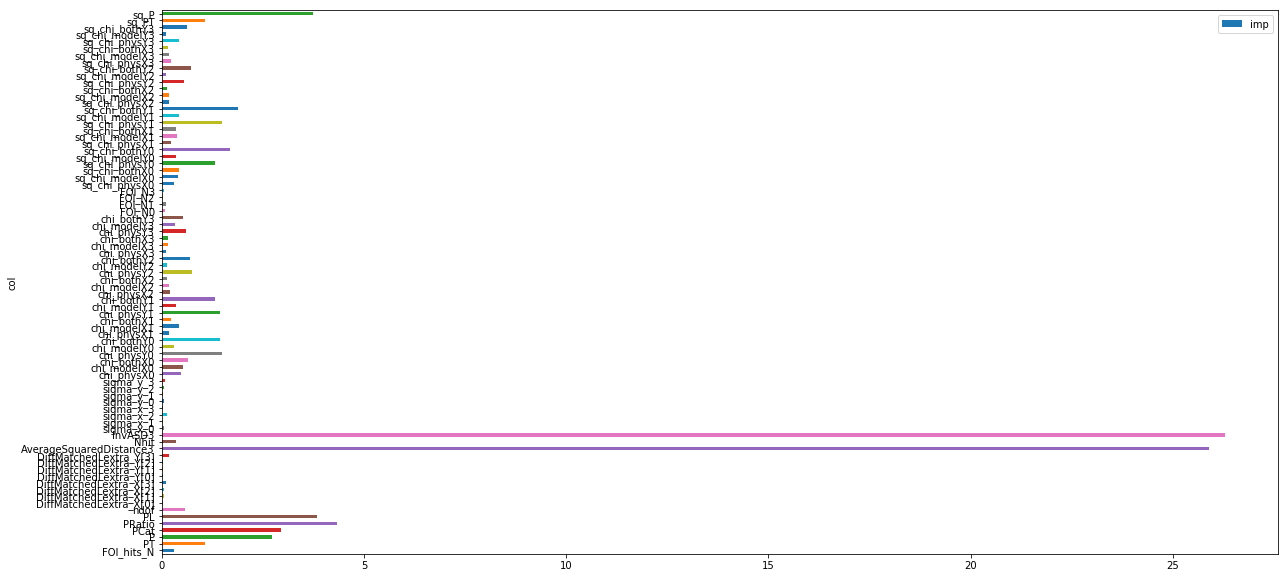

In [307]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X_train.columns})
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))

## モデル保存

In [308]:
modelname = "Cat_20190203_2"
modeldir="../models"

In [309]:
model.save_model(modeldir + '/' + modelname + ".cbm")

## 提出

In [310]:
test.head()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  \
id                                                                    
0       55      12      10      15   2.127273   1.166667   1.500000   
1       43      18      12      15   2.697674   1.111111   1.333333   
2       90      34      19      29   1.800000   2.058824   1.210526   
3      141      43      15      16   4.609929   2.744186   1.466667   
4       22      18       8       9   1.636364   2.444444   1.000000   

    avg_cs[3]  ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
id                                                            
0    1.600000     8                   2                   2   
1    1.600000     8                   2                   2   
2    1.344828     8                   2                   2   
3    1.125000     8                   2                   2   
4    1.555556     8                   2                   2   

    MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  MatchedHit_X[1]  \
id                                                                             
0                    2                   2        -22.33000         13.76000   
1                    2                   2      -1070.45500      -1156.07500   
2                    2                   2      -3348.08000      -3614.30000   
3                    1                   2       -213.62167       -238.30833   
4                    1                   1       -446.33835       -496.34167   

    MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  MatchedHit_Y[1]  \
id                                                                       
0          60.00000          65.7200      -1849.33730      -1833.79680   
1       -1202.87000       -1286.0700       -222.24156       -240.82657   
2       -3848.97000       -4113.1700      -1628.13240      -1758.31680   
3        -258.33667        -293.3700        483.45386        520.71850   
4        -550.00336        -588.4033        264.65280        284.41754   

    MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  MatchedHit_Z[1]  \
id                                                                       
0       -1968.07280      -2102.56400        15396.441        16404.695   
1        -258.19052       -274.01960        15117.299        16321.432   
2       -1887.17990      -2014.60830        15112.236        16315.968   
3         559.30420        663.87054        15119.840        16324.174   
4         305.50333        328.02402        15203.053        16407.324   

    MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  MatchedHit_DX[1]  \
id                                                                         
0         17597.812        18806.229         12.750000         13.750000   
1         17514.170        18722.213          6.375000          6.875000   
2         17508.303        18715.945         25.500000         27.500000   
3         17517.113        18926.592          3.208333          3.458333   
4         17600.200        18808.380          3.208333          3.458333   

    MatchedHit_DX[2]  MatchedHit_DX[3]  MatchedHit_DY[0]  MatchedHit_DY[1]  \
id                                                                           
0          59.000000         63.000000         63.078957         68.078926   
1          29.500000         31.500000         31.479162         33.979145   
2         118.000000        126.000000        126.278550        136.278490   
3          14.833333         31.500000         15.679264         16.929256   
4          14.833333         15.833333         15.679264         16.929256   

    MatchedHit_DY[2]  MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  \
id                                                                           
0          73.078896         78.078860         33.727364         33.745370   
1          36.479130         38.979115         33.613575         33.622578   
2         146.278410        156.278350         33.954950         33.99096

In [311]:
test.describe()

ncl[0]         ncl[1]         ncl[2]         ncl[3]  \
count  726095.000000  726095.000000  726095.000000  726095.000000   
mean       62.811942      19.554897      12.448600      13.012038   
std        32.264048      12.681014       7.451726       6.375977   
min         2.000000       0.000000       0.000000       0.000000   
25%        39.000000      10.000000       7.000000       8.000000   
50%        58.000000      17.000000      11.000000      12.000000   
75%        82.000000      26.000000      16.000000      16.000000   
max       285.000000     196.000000      84.000000      81.000000   

           avg_cs[0]      avg_cs[1]      avg_cs[2]      avg_cs[3]  \
count  726095.000000  726095.000000  726095.000000  726095.000000   
mean        2.466626       2.118251       1.447288       1.359854   
std         0.657863       0.778726       0.368397       0.430181   
min         1.000000       0.000000       0.000000       0.000000   
25%         2.012987       1.571428       1.185185       1.125000   
50%         2.386792       2.000000       1.388889       1.285714   
75%         2.822581       2.500000       1.636364       1.500000   
max        10.904762      25.666666       9.571428      16.500000   

                ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
count  726095.000000       726095.000000       726095.000000   
mean        7.931243            1.962469            1.964324   
std         0.400455            0.190059            0.185481   
min         4.000000            1.000000            1.000000   
25%         8.000000            2.000000            2.000000   
50%         8.000000            2.000000            2.000000   
75%         8.000000            2.000000            2.000000   
max         8.000000            2.000000            2.000000   

       MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  \
count       726095.000000       726095.000000    726095.000000   
mean             1.800077            1.788570        -0.265976   
std              0.439050            0.450192      1547.473481   
min              0.000000            0.000000     -4862.180000   
25%              2.000000            2.000000      -815.455000   
50%              2.000000            2.000000         7.558333   
75%              2.000000            2.000000       813.075000   
max              2.000000            2.000000      4832.950000   

       MatchedHit_X[1]  MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  \
count    726095.000000    726095.000000    726095.000000    726095.000000   
mean         -0.494001      -164.333201      -183.128382        -4.334283   
std        1690.196022      2218.311490      2344.461028      1346.489794   
min       -5243.800000     -9999.000000     -9999.000000     -3951.223600   
25%        -884.325000     -1042.870000     -1114.070000      -793.841700   
50%           8.068334       -37.870000       -41.370000       -32.562122   
75%         883.185000       918.600000       982.220000       783.449400   
max        5209.310000      5557.000000      5933.120000      3898.132300   

       MatchedHit_Y[1]  MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  \
count    726095.000000    726095.000000    726095.000000    726095.000000   
mean         -5.034248      -168.809096      -183.127655     15261.422972   
std        1450.342314      1990.991526      2090.162551       108.476325   
min       -4259.906700     -9999.000000     -9999.000000     15105.030000   
25%        -857.026370      -958.983150     -1023.974800     15190.861000   
50%         -35.208393       -74.082610       -78.923350     15257.947000   
75%         844.163940       902.111100       932.315700     15332.404000   
max        4205.364300      4512.695300      4820.811000     15418.309000   

       MatchedHit_Z[1]  MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  \
count    726095.000000    726095.000000    726095.000000     726095.000000   
mean      16467.135053     17206.558442     18349.6402

In [312]:
test_selected = test[FEATURE_COLUMNS2]

In [313]:
test_selected.head()

FOI_hits_N           PT             P  PCat    PRatio        PL  ndof  \
id                                                                          
0            6  1174.484530   6884.502272     1  0.170598   6783.58     8   
1            7  4344.639775  48769.526891     6  0.089085  48575.62     8   
2            4  4109.805750  20296.048412     4  0.202493  19875.59     8   
3            9   940.242439  26062.046122     4  0.036077  26045.08     8   
4            8  1386.377851  59872.343332     7  0.023156  59856.29     8   

    DiffMatchedLextra_X[0]  DiffMatchedLextra_X[1]  DiffMatchedLextra_X[2]  \
id                                                                           
0                -2.290999              -41.915945               -71.39090   
1                 7.529900               -3.351200                24.59260   
2                38.099400               64.605300               122.66130   
3                12.293410               25.395950                43.15683   
4                -1.777010               -8.109370               -18.10010   

    DiffMatchedLextra_X[3]  DiffMatchedLextra_Y[0]  DiffMatchedLextra_Y[1]  \
id                                                                           
0               -141.38583               -52.02300               102.23580   
1                 16.13150                34.86269                36.60583   
2                151.18740                -0.80790                -3.37530   
3                 45.91270               -13.17938               -14.89780   
4                -12.82900                 3.66174                 2.82132   

    DiffMatchedLextra_Y[2]  DiffMatchedLextra_Y[3]  AverageSquaredDistance3  \
id                                                                            
0                106.67820               110.90520                 3.179820   
1                 39.57004                44.06910                 6.049038   
2                 -4.62130                -4.43260                 5.244695   
3                -15.29510                50.28820                 7.825575   
4                  3.30193                 5.21747                 1.746150   

    Nhit   InvASD3  sigma_x_0   sigma_x_1  sigma_x_2  sigma_x_3  sigma_y_0  \
id                                                                           
0      4  0.314483   0.000000   14.019503   0.000000    0.00000   0.000000   
1      4  0.165316   8.500000   44.687500  29.500000    0.00000  80.652620   
2      4  0.190669   0.000000    0.000000   0.000000    0.00000   0.000000   
3      4  0.127786  15.030523    0.000000  32.106596    0.00000  59.803728   
4      4  0.572688   0.000000  202.679165   0.000000   21.22369   0.000000   

    sigma_y_1  sigma_y_2  sigma_y_3  chi_physX0  chi_modelX0  chi_bothX0  \
id                                                                         
0   72.016832   0.000000    0.00000    0.032287     0.004374    0.003852   
1    0.000000   0.000000    0.00000    1.395141     2.570106    0.904271   
2    0.000000   0.000000    0.00000    2.232317    10.386821    1.837422   
3    0.000000  28.706532    0.00000   14.682019     2.070748    1.814791   
4   41.425980   0.000000   17.95055    0.306776     0.229778    0.131376   

    chi_physY0  chi_modelY0  chi_bothY0  chi_physX1  chi_modelX1  chi_bothX1  \
id                                                                             
0     0.680177     2.235290    0.521492    9.292940     0.512037    0.485297   
1     1.226522    55.287497    1.199903    0.237605     0.176091    0.101137   
2     0.000041     0.004894    0.000041    5.519134    10.388201    3.604241   
3     0.706543     2.379956    0.544805   53.925631     3.047911    2.884857   
4     0.054541     0.976703    0.051656    5.498453     1.683626    1.288950   

    chi_physY1  chi_modelY1  chi_bothY1  chi_physX2  chi_modelX2  chi_bothX2  \
id                                                                             
0     2.255177 

In [314]:
predictions = model.predict_proba(test_selected)[:,1]

In [315]:
submissionname = "Cat_20190203_2"
submissiondir = "../submission"

In [316]:
pd.DataFrame(data={"prediction":predictions}, index=test_selected.index).to_csv(submissiondir + '/' + submissionname + ".csv", index_label=utils.ID_COLUMN)


